In [ ]:
import sys
import cv2

import matplotlib.pyplot as plt
import subprocess


import logging
import glob
from utils.data_processing import load_landmark_openface,compute_crop_radius

from utils.deep_speech import DeepSpeech
from models.Discriminator import Discriminator
from models.VGG19 import Vgg19
from models.DINet import DINet
from models.Syncnet import SyncNetPerception
# dengjunli 加上边缘检测的loss
from models.EdgeDetector import Sobel_Edge_Detection

from utils.training_utils import get_scheduler, update_learning_rate, GANLoss
from config.config import DINetTrainingOptions
from sync_batchnorm import convert_model
from torch.utils.data import DataLoader
from dataset.dataset_DINet_clip import DINetDataset

from models.Gaussian_blur import Gaussian_bluring

from tqdm import tqdm

import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import os
import torch.nn.functional as F

import wandb
from apex import amp

In [ ]:
# 定义数据预处理的函数
   
def dynamic_mask(source_clip_mask,frame_landmark,top,left,heatmap_layer,resize_w,resize_h):
    # print("DINetDataset,dynamic_mask,并取消黑色硬正方形mask")

    # print("source_clip_mask.shape:",source_clip_mask.shape)

    # 1-3. 根据序号，for循环5次，分别处理每一张图片
    source_clip_mask = source_clip_mask.cuda()


    # # print("source_image_path_list:",source_image_path_list)

    # # 1. 获取文件名中的数字部分，并转换为整数 
    # filename = os.path.basename(source_image_path_list[source_random_index]) # 
    # # print("循环内File name:", filename)
    # image_num = int(os.path.splitext(filename)[0])  # 获取文件名中的数字部分，并转换为整数
    # # print("循环内Image number:", image_num)

    # # top_left_key = 
    # # 找到倒数第二个斜杠(/)和第三个斜杠(/)的位置
    # pos1 = source_image_path_list[source_random_index].rfind('/')
    # pos2 = source_image_path_list[source_random_index][:pos1-1].rfind('/')

    # # 删除倒数第二个斜杠(/)和第三个斜杠(/)包裹的字符
    # top_left_key = source_image_path_list[source_random_index][:pos2+1] + source_image_path_list[source_random_index][pos1+1:]

    # # 将_crop_face替换为_frame
    # top_left_key = top_left_key.replace('_crop_face', '_frame')

    # if top_left_key in self.top_left_dict:
    #     # print("Key exists in the dictionary")
    #     pass
    # else:
    #     print(top_left_key,"Key does not exist in the dictionary")
    #     return F.interpolate(source_clip_mask.unsqueeze(0), size=(self.img_h,self.img_w), mode='bilinear', align_corners=False).squeeze()


    # frame_landmark = landmark_openface_data[image_num, :, :] 
    # 单帧的 landmark 数据，此时是全图的landmark

    ##################### 换算成以crop后的图像为坐标系的landmark值 #############

    # Load
    # load_dict = np.load('./asserts/training_data/left_top_dir.npy').item()
    # print("load_dict[source_image_path_list[i+2]]:",load_dict[source_image_path_list[i+2]])

    # import pdb
    # pdb.set_trace()

    frame_landmark[:,0] = frame_landmark[:,0] - left # X
    frame_landmark[:,1] = frame_landmark[:,1] - top # Y

    # copy from test_affine_estimate.ipynb ######################

    # 2. 初始化用来做遮罩的mask (image_tensor = source_clip_mask[i,:,:,:])
    heatmap_mask = torch.zeros_like(source_clip_mask[:,:,:]).cuda()
    # print("初始化用来做遮罩的mask heatmap.shape",heatmap_mask.shape)            
    
    # 3. 取出重要区域的landmark点
    landmarks_keys_test1 = frame_landmark[3:14,:] #
    landmarks_keys_test2 = frame_landmark[48:,:] # 
    landmarks_keys_test10 = frame_landmark[6:11,:] #

    landmarks_keys_test11 = (landmarks_keys_test1 - frame_landmark[30:31,:])*0.7 + frame_landmark[30:31,:]
    landmarks_keys_test12 = (landmarks_keys_test1 - frame_landmark[30:31,:])*0.9 + frame_landmark[30:31,:]
    landmarks_keys_test21 = (landmarks_keys_test2 - frame_landmark[30:31,:])*1.2 + frame_landmark[30:31,:]

    # import pdb
    # pdb.set_trace()

    landmarks_keys_test = np.concatenate((landmarks_keys_test11,landmarks_keys_test21,landmarks_keys_test12,landmarks_keys_test2,landmarks_keys_test10),axis=0)


    landmarks_index_X_test = torch.from_numpy(landmarks_keys_test)[:,0].round().type(torch.LongTensor).squeeze().cuda()
    # print("所有X的值:",landmarks_index_X_test)

    landmarks_index_Y_test = torch.from_numpy(landmarks_keys_test)[:,1].round().type(torch.LongTensor).squeeze().cuda()



    # print("矫正前 landmarks_index_X_test:",landmarks_index_X_test)
    # print("矫正前 landmarks_index_Y_test:",landmarks_index_Y_test)

    # 将超出图像范围的坐标设置为图像的长或宽
    # landmarks_index_Y_test[landmarks_index_Y_test > heatmap_mask.shape[1]] = heatmap_mask.shape[2]
    # landmarks_index_X_test[landmarks_index_X_test > heatmap_mask.shape[0]] = heatmap_mask.shape[1]
    # import pdb
    # pdb.set_trace()

    landmarks_index_Y_test = torch.where(landmarks_index_Y_test >= heatmap_mask.shape[1],heatmap_mask.shape[1]-1,landmarks_index_Y_test)
    landmarks_index_X_test = torch.where(landmarks_index_X_test >= heatmap_mask.shape[2],heatmap_mask.shape[2]-1,landmarks_index_X_test)
    # print("heatmap_mask.shape[1]:",heatmap_mask.shape[1])
    # print("heatmap_mask.shape[2]:",heatmap_mask.shape[2])
    

    # 将小于0的坐标设置为0
    landmarks_index_Y_test = torch.where(landmarks_index_Y_test <= 0,torch.tensor(1).cuda(),landmarks_index_Y_test)
    landmarks_index_X_test = torch.where(landmarks_index_X_test <= 0,torch.tensor(1).cuda(),landmarks_index_X_test)

    # landmarks_index_Y_test[landmarks_index_Y_test < 0] = 0
    # landmarks_index_X_test[landmarks_index_X_test < 0] = 0

    # print("矫正后 landmarks_index_X_test:",landmarks_index_X_test)
    # print("矫正后 landmarks_index_Y_test:",landmarks_index_Y_test)

    # 检查张量是否所有元素都大于0
    # if (landmarks_index_Y_test > 0).all():
    #     print("landmarks_index_Y_test > 0")
    # else:
    #     print("landmarks_index_Y_test <= 0")

    # if (landmarks_index_X_test > 0).all():
    #     print("landmarks_index_X_test > 0")
    # else:
    #     print("landmarks_index_X_test <= 0")

    

    # print("landmarks_index_X_test.max:",landmarks_index_X_test.max())
    # print("landmarks_index_Y_test.max:",landmarks_index_Y_test.max())

    # print("landmarks_index_X_test.min:",landmarks_index_X_test.min())
    # print("landmarks_index_Y_test.min:",landmarks_index_Y_test.min())
    # print("heatmap_mask",heatmap_mask.shape)
    # 4. 根据landmark点，生成遮罩
    heatmap_mask[:,landmarks_index_Y_test,landmarks_index_X_test] = torch.tensor([[1.,1.,1.]]).view(3,1).cuda() #可能有问题 可能landmark越界了
    # print("heatmap_mask[:,:,landmarks_index_Y,landmarks_index_X].shape",heatmap_mask[:,landmarks_index_Y_test,landmarks_index_X_test].shape)

    
    # print("heatmap_layer 前",heatmap_mask.shape)
    # print("heatmap_mask.unsqueeze()",heatmap_mask.unsqueeze(0).shape)
    heatmap_mask = heatmap_layer(heatmap_mask)
    # print("heatmap_layer 后",heatmap_mask.shape)

    heatmap_mask = heatmap_mask.squeeze()/heatmap_mask.max() # 归一化

    # 5. 将遮罩赋值给source_clip_mask
    w_mask = torch.sigmoid((heatmap_mask-0.02)*100).cuda()  ###########

    # # 将接近于0的数置为0
    w_mask[(w_mask < 0.0001)] = 0

    # print("w_mask.shape:",w_mask.shape)

    # plt.imsave('frame_数据预处理-heatmap_mask_遮罩.png',w_mask.permute(1,2,0).cpu().numpy())

    # 6. 将均值赋予空缺处
    # 统计heatmap中大于0的像素位置

    # 这段求均值的有问题，借鉴之前求均值的代码

    # import pdb
    # pdb.set_trace()

    # 判断哪些像素值大于0
    mask = (w_mask > 0).any(dim=0)

    # 获取满足条件的像素点的 x 和 y 坐标位置
    indices = torch.nonzero(mask)

    # 分别计算每个颜色通道上的均值
    r_mean = source_clip_mask[:,:,:][0, indices[:, 0], indices[:, 1]].mean()
    g_mean = source_clip_mask[:,:,:][1, indices[:, 0], indices[:, 1]].mean()
    b_mean = source_clip_mask[:,:,:][2, indices[:, 0], indices[:, 1]].mean()

    # 将大于0的像素点替换成相应通道的均值
    # source_clip_mask[i,:,:,:][0, indices[:, 0], indices[:, 1]] = r_mean
    # source_clip_mask[i,:,:,:][1, indices[:, 0], indices[:, 1]] = g_mean
    # source_clip_mask[i,:,:,:][2, indices[:, 0], indices[:, 1]] = b_mean

    # import pdb
    # pdb.set_trace()

    # 分别创建 r_mean、g_mean、b_mean 的张量
    r_tensor = torch.full((1, source_clip_mask[:,:,:].shape[1], source_clip_mask[:,:,:].shape[2]), fill_value=r_mean)
    g_tensor = torch.full((1, source_clip_mask[:,:,:].shape[1], source_clip_mask[:,:,:].shape[2]), fill_value=g_mean)
    b_tensor = torch.full((1, source_clip_mask[:,:,:].shape[1], source_clip_mask[:,:,:].shape[2]), fill_value=b_mean)

    tensor_mean_rgb = torch.cat((r_tensor, g_tensor, b_tensor), dim=0).cuda()

    # import pdb
    # pdb.set_trace()

    source_clip_mask[:,:,:] = source_clip_mask[:,:,:]*(1-w_mask) + tensor_mean_rgb*w_mask        

    # 将数组保存为图像文件 debug
    # plt.imsave('数据预处理——应该自带黑色口罩——1.png', source_clip_mask[i,:,:,:].squeeze().permute(1,2,0).cpu().numpy())
    # image_tensor_mix = source_clip_mask[i,:,:,:]*(1-torch.sigmoid((heatmap_mask-0.02)*100))

    # import pdb
    # pdb.set_trace()

    # plt.imsave('数据预处理——应该自带黑色口罩——2——更清晰.png', image_tensor_mix.squeeze().permute(1,2,0).numpy())

    plt.imsave('实验1-frame_数据预处理——填充平均色——frame.png', source_clip_mask[:,:,:].squeeze().permute(1,2,0).cpu().numpy())

    # print("source_clip_mask.shape:",source_clip_mask.shape)
    # print("self.img_w:",self.img_w)
    # print("self.img_h:",self.img_h)

    resized_tensor = F.interpolate(source_clip_mask.unsqueeze(0), size=(resize_h,resize_w), mode='bilinear', align_corners=False)

    # print("resized_tensor.shape:",resized_tensor.shape)
    return resized_tensor

In [ ]:
# 定义拆帧的函数
def extract_frames_from_video(video_path,save_dir):
    videoCapture = cv2.VideoCapture(video_path)
    fps = videoCapture.get(cv2.CAP_PROP_FPS)
    if int(fps) != 25:
        print('warning: the input video is not 25 fps, it would be better to trans it to 25 fps!')
    frames = videoCapture.get(cv2.CAP_PROP_FRAME_COUNT)
    frame_height = videoCapture.get(cv2.CAP_PROP_FRAME_HEIGHT)
    frame_width = videoCapture.get(cv2.CAP_PROP_FRAME_WIDTH)
    for i in range(int(frames)):
        ret, frame = videoCapture.read()
        result_path = os.path.join(save_dir, str(i).zfill(6) + '.jpg')
        cv2.imwrite(result_path, frame)
    return (int(frame_width),int(frame_height))

In [ ]:
# config
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# opt = DINetTrainingOptions().parse_args()


In [ ]:
# 初始化必要的模块
# 先固定opt参数
source_video_path = "./asserts/examples/RD_Radio14_000_corrected.mp4"
source_openface_landmark_path = "./asserts/examples/RD_Radio14_000_corrected.csv"
driving_audio_path = "./asserts/examples/RD_Radio14_000_corrected.wav"

# source_video_path = "./asserts/examples/test1.mp4"
# source_openface_landmark_path = "./asserts/examples/test1.csv"
# driving_audio_path = "./asserts/examples/driving_audio_1.wav"

# 实验1
pretrained_clip_DINet_path = "./asserts/training_model_weight/clip_training_256/netG_model_epoch_100.pth"

# dengjunli复现作者的
# pretrained_clip_DINet_path = "./asserts/training_model_weight-复现作者原模型/clip_training_256/netG_model_epoch_100.pth"

# 作者自己的
# pretrained_clip_DINet_path = "./asserts/clip_training_DINet_256mouth.pth"

deepspeech_model_path = "./asserts/output_graph.pb"
mouth_region_size = 256
res_video_dir = './asserts/inference_result'


######## 初始化模型
net_g = DINet(3,15,29).cuda()

# parallel
net_g = nn.DataParallel(net_g)
net_g = convert_model(net_g)


checkpoint = torch.load(pretrained_clip_DINet_path)
# print("更改了加载预训练模型的路径！！！！！！！！！")

net_g.load_state_dict(checkpoint['state_dict']['net_g'])

# net_g.eval()
net_g.train()

In [ ]:


heatmap_layer = Gaussian_bluring(radius=60,sigma=20,padding='same')

# 拆帧
print('extracting frames from video: {}'.format(source_video_path))
video_frame_dir = source_video_path.replace('.mp4', '')
if not os.path.exists(video_frame_dir):
    os.mkdir(video_frame_dir)
video_size = extract_frames_from_video(source_video_path,video_frame_dir)

# 音频变成deepspeech
print('extracting deepspeech feature from : {}'.format(driving_audio_path))
if not os.path.exists(deepspeech_model_path):
    raise ('pls download pretrained model of deepspeech')
DSModel = DeepSpeech(deepspeech_model_path)
if not os.path.exists(driving_audio_path):
    raise ('wrong audio path :{}'.format(driving_audio_path))
ds_feature = DSModel.compute_audio_feature(driving_audio_path)
res_frame_length = ds_feature.shape[0]
ds_feature_padding = np.pad(ds_feature, ((2, 2), (0, 0)), mode='edge')


# 读取openface的landmark
print('loading facial landmarks from : {}'.format(source_openface_landmark_path))
video_frame_path_list = glob.glob(os.path.join(video_frame_dir, '*.jpg'))
if not os.path.exists(source_openface_landmark_path):
    raise ('wrong facial landmark path :{}'.format(source_openface_landmark_path))
video_landmark_data = load_landmark_openface(source_openface_landmark_path,len(video_frame_path_list)).astype(np.int64)
############################################## align frame with driving audio ##############################################
print('aligning frames with driving audio')

if len(video_frame_path_list) != video_landmark_data.shape[0]:
    print("len(video_frame_path_list):",len(video_frame_path_list))
    print("video_landmark_data.shape[0]:",video_landmark_data.shape[0])

    # raise ('video frames are misaligned with detected landmarks')
video_frame_path_list.sort()
video_frame_path_list_cycle = video_frame_path_list + video_frame_path_list[::-1]
video_landmark_data_cycle = np.concatenate([video_landmark_data, np.flip(video_landmark_data, 0)], 0)
video_frame_path_list_cycle_length = len(video_frame_path_list_cycle)
if video_frame_path_list_cycle_length >= res_frame_length:
    res_video_frame_path_list = video_frame_path_list_cycle[:res_frame_length]
    res_video_landmark_data = video_landmark_data_cycle[:res_frame_length, :, :]
else:
    divisor = res_frame_length // video_frame_path_list_cycle_length
    remainder = res_frame_length % video_frame_path_list_cycle_length
    res_video_frame_path_list = video_frame_path_list_cycle * divisor + video_frame_path_list_cycle[:remainder]
    res_video_landmark_data = np.concatenate([video_landmark_data_cycle]* divisor + [video_landmark_data_cycle[:remainder, :, :]],0)
res_video_frame_path_list_pad = [video_frame_path_list_cycle[0]] * 2 \
                                + res_video_frame_path_list \
                                + [video_frame_path_list_cycle[-1]] * 2
res_video_landmark_data_pad = np.pad(res_video_landmark_data, ((2, 2), (0, 0), (0, 0)), mode='edge')
assert ds_feature_padding.shape[0] == len(res_video_frame_path_list_pad) == res_video_landmark_data_pad.shape[0]
pad_length = ds_feature_padding.shape[0]



In [ ]:

# ############################################## randomly select 5 reference images ##############################################
# print('selecting five reference images')
# ref_img_list = []
resize_w = int(mouth_region_size + mouth_region_size // 4)
resize_h = int((mouth_region_size // 2) * 3 + mouth_region_size // 8)
ref_index_list = random.sample(range(5, len(res_video_frame_path_list_pad) - 2), 5)
for ref_index in ref_index_list:
    crop_flag,crop_radius = compute_crop_radius(video_size,res_video_landmark_data_pad[ref_index - 5:ref_index, :, :])
    if not crop_flag:
        raise ('our method can not handle videos with large change of facial size!!')
    crop_radius_1_4 = crop_radius // 4
    ref_img = cv2.imread(res_video_frame_path_list_pad[ref_index- 3])[:, :, ::-1]
    ref_landmark = res_video_landmark_data_pad[ref_index - 3, :, :]
    ref_img_crop = ref_img[
                ref_landmark[29, 1] - crop_radius:ref_landmark[29, 1] + crop_radius * 2 + crop_radius_1_4,
                ref_landmark[33, 0] - crop_radius - crop_radius_1_4:ref_landmark[33, 0] + crop_radius +crop_radius_1_4,
                :]
    ref_img_crop = cv2.resize(ref_img_crop,(resize_w,resize_h))
    ref_img_crop = ref_img_crop / 255.0
    ref_img_list.append(ref_img_crop)
ref_video_frame = np.concatenate(ref_img_list, 2)
ref_img_tensor = torch.from_numpy(ref_video_frame).permute(2, 0, 1).unsqueeze(0).float().cuda()

print("ref_img_tensor",ref_img_tensor.shape)

In [ ]:
# source_video_path
# os.path.basename(source_video_path)[:-4]
# res_video_dir
if not os.path.exists(res_video_dir):
    os.mkdir(res_video_dir)
res_video_path = os.path.join(res_video_dir,os.path.basename(source_video_path)[:-4] + '_facial_dubbing.mp4')

In [ ]:
if not os.path.exists(res_video_dir):
    os.mkdir(res_video_dir)
res_video_path = os.path.join(res_video_dir,os.path.basename(source_video_path)[:-4] + '_facial_dubbing.mp4')
if os.path.exists(res_video_path):
    os.remove(res_video_path)
res_face_path = res_video_path.replace('_facial_dubbing.mp4', '_synthetic_face.mp4')
print("res_video_path: ", res_video_path)

if os.path.exists(res_face_path):
    os.remove(res_face_path)
videowriter = cv2.VideoWriter(res_video_path, cv2.VideoWriter_fourcc(*'XVID'), 25, video_size)
videowriter_face = cv2.VideoWriter(res_face_path, cv2.VideoWriter_fourcc(*'XVID'), 25, (resize_w, resize_h))


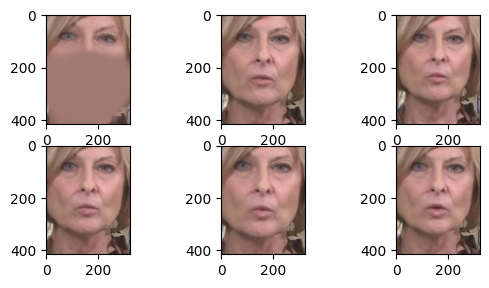

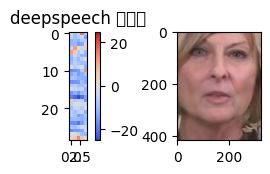

synthesizing 97/1250 frame
ref_img_tensor torch.Size([1, 15, 416, 320])


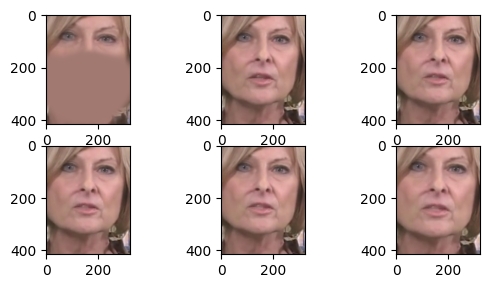

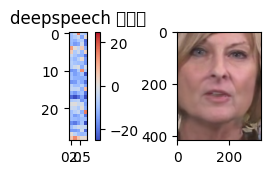

In [11]:
for clip_end_index in range(5, pad_length, 1):
    print('synthesizing {}/{} frame'.format(clip_end_index - 5, pad_length - 5))
    crop_flag, crop_radius = compute_crop_radius(video_size,res_video_landmark_data_pad[clip_end_index - 5:clip_end_index, :, :],random_scale = 1.05)
    if not crop_flag:
        raise ('our method can not handle videos with large change of facial size!!')
    crop_radius_1_4 = crop_radius // 4
    frame_data = cv2.imread(res_video_frame_path_list_pad[clip_end_index - 3])[:, :, ::-1]
    frame_landmark = res_video_landmark_data_pad[clip_end_index - 3, :, :]
    crop_frame_data = frame_data[
                        frame_landmark[29, 1] - crop_radius:frame_landmark[29, 1] + crop_radius * 2 + crop_radius_1_4,
                        frame_landmark[33, 0] - crop_radius - crop_radius_1_4:frame_landmark[33, 0] + crop_radius +crop_radius_1_4,
                        :]
    crop_frame_h,crop_frame_w = crop_frame_data.shape[0],crop_frame_data.shape[1]

    # crop_frame_data = cv2.resize(crop_frame_data, (resize_w,resize_h))  # [32:224, 32:224, :]
    # origin

    crop_frame_data = crop_frame_data / 255.0

    # crop_frame_data[mouth_region_size//2:mouth_region_size//2 + mouth_region_size,
    #                 mouth_region_size//8:mouth_region_size//8 + mouth_region_size, :] = 0
    # origin

    # crop_frame_tensor = torch.from_numpy(crop_frame_data).float().cuda().permute(2, 0, 1).unsqueeze(0)
    # origin

    crop_frame_tensor = torch.from_numpy(crop_frame_data).float().cuda().permute(2, 0, 1)
    # dengjunli

    deepspeech_tensor = torch.from_numpy(ds_feature_padding[clip_end_index - 5:clip_end_index, :]).permute(1, 0).unsqueeze(0).float().cuda()

    top = frame_landmark[29, 1] - crop_radius
    left = frame_landmark[33, 0] - crop_radius - crop_radius_1_4
    ############  修改实验1 数据预处理方式  ############

    # import pdb
    # pdb.set_trace()
    # print("加mask之前 crop_frame_tensor.shape:",crop_frame_tensor.shape)

    frame_landmark_crop = frame_landmark.copy()
    
    # 循环中计算单帧图像
    crop_frame_tensor = dynamic_mask(crop_frame_tensor,frame_landmark_crop,top,left,heatmap_layer,resize_w,resize_h)




    # 加维度
    # batch_crop_frame_tensor = crop_frame_tensor.repeat(5,1,1,1)
    # batch_ref_img_tensor = ref_img_tensor.repeat(5,1,1,1)
    # batch_deepspeech_tensor = deepspeech_tensor.repeat(5,1,1)
    # 1 29 5
    # 5 29 5
    ####### luo
    # ref_img_list = []
    # ref_index_list = random.sample(range(5, len(res_video_frame_path_list_pad) - 5), 1)
    # for ref_index in range(ref_index_list[0],ref_index_list[0]+5):
    #     crop_flag,crop_radius = compute_crop_radius(video_size,res_video_landmark_data_pad[ref_index - 5:ref_index, :, :])
    #     if not crop_flag:
    #         raise ('our method can not handle videos with large change of facial size!!')
    #     crop_radius_1_4 = crop_radius // 4
    #     ref_img = cv2.imread(res_video_frame_path_list_pad[ref_index- 3])[:, :, ::-1]
    #     ref_landmark = res_video_landmark_data_pad[ref_index - 3, :, :]
    #     ref_img_crop = ref_img[
    #                 ref_landmark[29, 1] - crop_radius:ref_landmark[29, 1] + crop_radius * 2 + crop_radius_1_4,
    #                 ref_landmark[33, 0] - crop_radius - crop_radius_1_4:ref_landmark[33, 0] + crop_radius +crop_radius_1_4,
    #                 :]
    #     ref_img_crop = cv2.resize(ref_img_crop,(320,416))
    #     ref_img_crop = ref_img_crop / 255.0
    #     ref_img_list.append(ref_img_crop)
    # ref_video_frame = np.concatenate(ref_img_list, -1)
    # ref_img_tensor = torch.from_numpy(ref_video_frame).permute(2, 0, 1).unsqueeze(0).float().cuda()

    # print("ref_img_tensor",ref_img_tensor.shape)
    ####################


    # anthor = random.sample(range(5, len(res_video_frame_path_list_pad) - 5), 1)[0]
    # ref_img_list = []

    # for i in range(5):
    #     # a = cv2.imread(res_video_frame_path_list_pad[anthor+i])[:, :, ::-1]
    #     # print("a:",a)
    #     cv2.resize(,(416,320))
    #     ref_img_list.append(cv2.imread(res_video_frame_path_list_pad[anthor+i])[:, :, ::-1])
    #     ref_img_list = 

    # ref_video_frame = np.concatenate(ref_img_list, -1)
    # print("ref_video_frame.shape",ref_video_frame.shape)

    # ref_img_tensor = torch.from_numpy(ref_video_frame).permute(2, 0, 1).unsqueeze(0).float().cuda()

    # print("ref_img_tensor",ref_img_tensor.shape)

    # 逐帧结果显示
    one,two,three = crop_frame_tensor, ref_img_tensor.view(5,3,416,320), deepspeech_tensor


        # 推理
    # with torch.no_grad():
    fake_out = net_g(crop_frame_tensor,ref_img_tensor,deepspeech_tensor)
        # fake_out = net_g(batch_crop_frame_tensor,batch_ref_img_tensor,batch_deepspeech_tensor)

    

    # if clip_end_index % 100 == 0:
    plt.subplot(3,3,1)
    plt.imshow(one[0].cpu().numpy().transpose(1,2,0))
    plt.subplot(3,3,2)
    plt.imshow(two[0].cpu().numpy().transpose(1,2,0))
    plt.subplot(3,3,3)
    plt.imshow(two[1].cpu().numpy().transpose(1,2,0))
    plt.subplot(3,3,4)
    plt.imshow(two[2].cpu().numpy().transpose(1,2,0))
    plt.subplot(3,3,5)
    plt.imshow(two[3].cpu().numpy().transpose(1,2,0))
    plt.subplot(3,3,6)
    plt.imshow(two[4].cpu().numpy().transpose(1,2,0))
    plt.show()

    plt.subplot(3,3,7)
    # 设置绘图
    plt.imshow(deepspeech_tensor[0].cpu().detach().numpy(), cmap='coolwarm', vmin=-25, vmax=25)
    plt.colorbar()
    plt.title('deepspeech 可视化')

    plt.subplot(3,3,8)
    plt.imshow(fake_out[0].cpu().detach().numpy().transpose(1,2,0))
    plt.show()
    # import pdb
    # pdb.set_trace()

    # break

    if clip_end_index % 5 == 0:
        import pdb
        pdb.set_trace()


    # import pdb
    # pdb.set_trace()

    pre_frame = fake_out.squeeze(0).permute(1, 2, 0).detach().cpu().numpy() * 255
    videowriter_face.write(pre_frame[:, :, ::-1].copy().astype(np.uint8))
    pre_frame_resize = cv2.resize(pre_frame, (crop_frame_w,crop_frame_h))
    frame_data[
    frame_landmark[29, 1] - crop_radius:
    frame_landmark[29, 1] + crop_radius * 2,
    frame_landmark[33, 0] - crop_radius - crop_radius_1_4:
    frame_landmark[33, 0] + crop_radius + crop_radius_1_4,
    :] = pre_frame_resize[:crop_radius * 3,:,:]
    videowriter.write(frame_data[:, :, ::-1])

    cv2.imwrite('./inference-实验1_生成结果.jpg', frame_data[:, :, ::-1])
    # import pdb
    # pdb.set_trace()

In [ ]:
# cv2.imread(res_video_frame_path_list_pad[anthor+i])

# res_video_frame_path_list_pad[anthor+i]
# anthor
ref_img_tensor.shape

In [ ]:
# 正脸化 
# 预处理封装成函数

# 合并成视频

In [ ]:
videowriter.release()
videowriter_face.release()

video_add_audio_path_1 = res_video_path.replace('.mp4', '_add_audio.mp4')
video_add_audio_path_2 = res_face_path.replace('.mp4', '_add_audio.mp4')
if os.path.exists(video_add_audio_path_1):
    os.remove(video_add_audio_path_1)
cmd = 'ffmpeg -i {} -i {} -c:v copy -c:a aac -strict experimental -map 0:v:0 -map 1:a:0 {}'.format(
    res_video_path,
    driving_audio_path,
    video_add_audio_path_1)
subprocess.call(cmd, shell=True)

cmd = 'ffmpeg -i {} -i {} -c:v copy -c:a aac -strict experimental -map 0:v:0 -map 1:a:0 {}'.format(
    res_face_path,
    driving_audio_path,
    video_add_audio_path_2)
subprocess.call(cmd, shell=True)
